In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [5]:
import os

In [9]:
train_dirs = []
for i in train_df['ID']:
    train_dirs.append(os.path.join('Train',i))
train_df['train dirs'] = train_dirs
train_df.head()

,ID,Class,train dirs
0,377.jpg,MIDDLE,Train\377.jpg
1,17814.jpg,YOUNG,Train\17814.jpg
2,21283.jpg,MIDDLE,Train\21283.jpg
3,16496.jpg,YOUNG,Train\16496.jpg
4,4487.jpg,MIDDLE,Train\4487.jpg


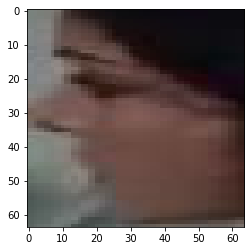

In [13]:
img = load_img(train_df['train dirs'][1000],target_size=(64,64,3))
plt.imshow(img)

In [14]:
X = np.zeros((len(train_df),64,64,3))
for i in range(len(train_df)):
    img = load_img(train_df['train dirs'][i],target_size=(64,64,3))
    arr = img_to_array(img)
    X[i] = arr
print(X.shape)

(19906, 64, 64, 3)


In [15]:
X_train,X_test = X[0:18000],X[18000:]

In [16]:
print(X_train.shape,X_test.shape)

(18000, 64, 64, 3) (1906, 64, 64, 3)


In [17]:
X_train = X_train/255.0
X_test = X_test/255.0
print(X_train.shape,X_test.shape)

(18000, 64, 64, 3) (1906, 64, 64, 3)


In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_df['class encode'] = encoder.fit_transform(train_df['Class'])
train_df.head()

,ID,Class,train dirs,class encode
0,377.jpg,MIDDLE,Train\377.jpg,0
1,17814.jpg,YOUNG,Train\17814.jpg,2
2,21283.jpg,MIDDLE,Train\21283.jpg,0
3,16496.jpg,YOUNG,Train\16496.jpg,2
4,4487.jpg,MIDDLE,Train\4487.jpg,0


In [22]:
Y = train_df['class encode'].values
print(Y[:10])
print(Y.shape)

[0 2 0 2 0 0 2 2 2 1]
(19906,)


In [23]:
Y_train,Y_test = Y[0:18000],Y[18000:]

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
inputs = Input(shape=(64,64,3))
x = layers.Conv2D(32,(3,3),activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(64,(3,3),activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128,(3,3),padding='same',activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512,activation='relu')(x)
outputs = layers.Dense(3,activation='softmax')(x)
model = Model(inputs,outputs)
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 128)         0   

In [31]:
callbacks_list = [
    ModelCheckpoint(monitor='val_loss',save_best_only=True,filepath='my_model.h5'),
    EarlyStopping(monitor='accuracy',patience=1)
]

In [33]:
H = model.fit(X_train,Y_train,batch_size=128,epochs=20,callbacks=callbacks_list,validation_data=(X_test,Y_test))

Train on 18000 samples, validate on 1906 samples
Epoch 1/20
18000/18000 [==============================] - 9s 498us/sample - loss: 0.9274 - accuracy: 0.5632 - val_loss: 0.7833 - val_accuracy: 0.6705
Epoch 2/20
18000/18000 [==============================] - 6s 310us/sample - loss: 0.7751 - accuracy: 0.6584 - val_loss: 0.7649 - val_accuracy: 0.6831
Epoch 3/20
18000/18000 [==============================] - 5s 302us/sample - loss: 0.7034 - accuracy: 0.6943 - val_loss: 0.8017 - val_accuracy: 0.6375
Epoch 4/20
18000/18000 [==============================] - 5s 303us/sample - loss: 0.6408 - accuracy: 0.7241 - val_loss: 0.6224 - val_accuracy: 0.7314
Epoch 5/20
18000/18000 [==============================] - 6s 318us/sample - loss: 0.5924 - accuracy: 0.7473 - val_loss: 0.6077 - val_accuracy: 0.7550
Epoch 6/20
18000/18000 [==============================] - 5s 303us/sample - loss: 0.5473 - accuracy: 0.7729 - val_loss: 0.5626 - val_accuracy: 0.7576
Epoch 7/20
18000/18000 [===========================

In [34]:
model.load_weights('my_model.h5')

In [35]:
test_df = pd.read_csv('test.csv')
test_df.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [37]:
len(test_df)

6636

In [41]:
test_dirs = []
for i in range(len(test_df)):
    test_dirs.append(os.path.join('Test',test_df['ID'][i]))
test_df['test dirs'] = test_dirs
test_df.head()

,ID,test dirs
0,25321.jpg,Test\25321.jpg
1,989.jpg,Test\989.jpg
2,19277.jpg,Test\19277.jpg
3,13093.jpg,Test\13093.jpg
4,5367.jpg,Test\5367.jpg


In [43]:
X_test = np.zeros((len(test_df),64,64,3))
for i in range(len(test_df)):
    path = test_df['test dirs'][i]
    img = load_img(path,target_size=(64,64,3))
    arr = img_to_array(img)
    X_test[i] = arr/255.0
print(X_test.shape)

(6636, 64, 64, 3)


In [49]:
y_pred = model.predict(X_test,batch_size=128)

In [45]:
print(y_pred.shape)

(6636, 3)


In [51]:
y_pred = np.array([np.argmax(x) for x in y_pred])
print(y_pred.shape)
print(y_pred[:1000])

(6636,)
[0 2 0 0 1 0 0 2 0 0 0 1 1 0 0 0 2 0 2 0 2 1 2 2 0 2 0 0 2 0 2 2 2 2 0 0 2
 1 2 2 0 0 0 2 0 2 2 2 0 0 2 2 0 2 0 1 2 0 2 0 2 0 0 2 2 1 1 0 1 2 0 0 2 0
 2 0 0 1 0 1 2 1 0 2 0 0 1 0 1 2 1 0 0 0 0 0 1 0 2 1 2 0 0 0 0 2 0 1 0 0 2
 2 2 2 2 0 0 2 0 1 0 0 0 2 2 0 0 0 0 2 0 2 0 0 0 2 0 0 2 0 1 2 1 0 0 0 0 2
 2 2 1 0 0 0 0 0 0 2 2 2 0 1 2 0 0 2 0 1 0 0 0 2 0 2 0 1 2 2 1 2 1 0 0 2 2
 1 1 0 0 0 0 0 2 2 0 2 0 2 0 2 0 1 1 0 2 2 0 0 0 2 0 0 2 0 2 2 0 0 2 0 1 0
 1 0 1 2 0 0 1 2 0 0 1 0 0 2 0 0 2 0 2 0 0 0 2 2 0 2 2 0 2 2 0 0 0 0 0 0 0
 0 0 2 2 0 1 0 2 1 0 0 0 0 0 2 0 0 1 2 2 2 2 2 2 1 1 0 0 2 2 0 2 2 0 0 0 2
 1 1 0 1 2 0 0 2 0 2 2 0 2 1 0 0 2 0 2 0 2 2 2 0 0 0 0 0 0 2 2 0 2 0 0 0 0
 0 0 2 0 0 2 0 0 0 0 0 0 1 2 0 2 2 0 0 0 0 2 0 0 0 1 0 2 2 1 0 2 2 2 2 0 1
 2 2 0 0 0 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 0 2 0 0 2 2 1 1 0 0 2 2 2 0 2 2 0
 0 1 0 0 0 2 2 2 2 0 2 2 2 1 2 0 2 2 0 2 2 0 0 2 1 2 0 2 0 2 0 0 2 2 0 0 0
 0 0 2 2 0 1 0 0 1 0 2 2 0 1 2 0 0 0 2 0 2 2 0 1 1 2 0 0 0 0 0 2 1 2 0 1 2
 0 0 0 2 0 0 0 0 

In [53]:
y_pred_inv = encoder.inverse_transform(y_pred)

In [54]:
y_pred_inv[:100]

array(['MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE', 'OLD', 'MIDDLE', 'MIDDLE',
       'YOUNG', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'OLD', 'OLD', 'MIDDLE',
       'MIDDLE', 'MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG',
       'OLD', 'YOUNG', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE',
       'YOUNG', 'MIDDLE', 'YOUNG', 'YOUNG', 'YOUNG', 'YOUNG', 'MIDDLE',
       'MIDDLE', 'YOUNG', 'OLD', 'YOUNG', 'YOUNG', 'MIDDLE', 'MIDDLE',
       'MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'YOUNG', 'YOUNG', 'MIDDLE',
       'MIDDLE', 'YOUNG', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'OLD',
       'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE',
       'YOUNG', 'YOUNG', 'OLD', 'OLD', 'MIDDLE', 'OLD', 'YOUNG', 'MIDDLE',
       'MIDDLE', 'YOUNG', 'MIDDLE', 'YOUNG', 'MIDDLE', 'MIDDLE', 'OLD',
       'MIDDLE', 'OLD', 'YOUNG', 'OLD', 'MIDDLE', 'YOUNG', 'MIDDLE',
       'MIDDLE', 'OLD', 'MIDDLE', 'OLD', 'YOUNG', 'OLD', 'MIDDLE',
       'MIDDLE', 'MIDDLE', 'MIDDLE', 'MIDDLE', 'OLD', 'MIDDLE', 'YOU

In [55]:
test_df['Class'] = y_pred_inv
test_df.head()

,ID,test dirs,Class
0,25321.jpg,Test\25321.jpg,MIDDLE
1,989.jpg,Test\989.jpg,YOUNG
2,19277.jpg,Test\19277.jpg,MIDDLE
3,13093.jpg,Test\13093.jpg,MIDDLE
4,5367.jpg,Test\5367.jpg,OLD


In [56]:
test_df.drop(['test dirs'],axis=1,inplace=True)
test_df.head()

,ID,Class
0,25321.jpg,MIDDLE
1,989.jpg,YOUNG
2,19277.jpg,MIDDLE
3,13093.jpg,MIDDLE
4,5367.jpg,OLD


In [57]:
cols = test_df.columns.tolist()
cols

['ID', 'Class']

In [58]:
cols = cols[-1:] + cols[:-1]
cols

['Class', 'ID']

In [59]:
test_df = test_df[cols]
test_df.head()

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,OLD,5367.jpg


In [61]:
pd.DataFrame(test_df).to_csv('submission_regCNN.csv',columns=['Class','ID'],index=None)
